In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import scipy.stats as sps
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm

In [55]:
def plot_insights(directory: str):
    data = np.load(f"outputs/{directory}/losses.npy")
    epochs = 0
    for i in range(data.shape[0]):
        if np.count_nonzero(data[i]) > 0:
            epochs += 1
            
    data = data[:epochs, :]
    
    true_labels = np.load(f'outputs/{directory}/true_labels.npy')
    corrupted_labels = np.load(f'outputs/{directory}/corrupted_labels.npy')
    labels_history = np.load(f'outputs/{directory}/labels_history.npy')[:epochs, :]
    val_accuracies = np.load(f'outputs/{directory}/val_accuracies.npy')[:epochs]
    train_accuracies = np.load(f'outputs/{directory}/train_accuracies.npy')[:epochs]
    train_predictions = np.load(f'outputs/{directory}/train_predictions.npy')[:epochs, :]
    is_corrupted = corrupted_labels != true_labels
    
    wds = []
    intersections = []
    gmm_diffs = []

    corrupted_fraction = (labels_history == true_labels).sum(axis=1) / labels_history.shape[1]
    corrupted_fraction = 1 - corrupted_fraction
    
    avg_loss = np.clip(data, 0, np.quantile(data, 0.99)).mean(axis=0)
    
    k, m = 4, 3
    fig, ax = plt.subplots(k, m, figsize=(12, 8))
    for i in range(k):
        for j in range(m):
            n = i * m + j
            epoch = min(int(n * (epochs / (k * m))), epochs - 1)
            clipped_data = data[epoch, :]
            clipped_data = np.clip(clipped_data, 0, np.quantile(clipped_data, 0.995))
            clipped_data = (clipped_data - np.mean(clipped_data)) / np.std(clipped_data)
            
            bins = np.linspace(min(clipped_data), max(clipped_data), 50)
            
            h1, _, _ = ax[i, j].hist(clipped_data[~is_corrupted], bins=bins, alpha=0.5, label='Clean Labels', density=True)
            h2, _, _ = ax[i, j].hist(clipped_data[is_corrupted], bins=bins, alpha=0.5, label='Corrupted Labels', density=True)
            ax[i, j].set_title(f'Epoch {epoch}')
            
            q4 = np.quantile(np.concat([h1, h2]), 0.75)
            q1 = np.quantile(np.concat([h1, h2]), 0.25)
            iqr = q4 - q1
            upper_bound = q4 + 10 * iqr
            ax[i, j].set_ylim(0, min(upper_bound, max(h1.max(), h2.max()) * 1.1))
            
            if i == 0 and j == 0:
                handles, labels = ax[i, j].get_legend_handles_labels()
    
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.01))
    
    plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.95])  # Adjust to make room for common labels
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()
    
    corr_pred_precisions = []
    corr_pred_recalls = []
    for epoch in tqdm(range(epochs)):
        scaled_data = data[epoch, :]
        scaled_data = (scaled_data - np.mean(scaled_data)) / np.std(scaled_data)
        wd = wasserstein_distance(scaled_data[~is_corrupted], scaled_data[is_corrupted])
        wds.append(wd)
        
        clipped_data = np.clip(
            scaled_data,
            np.quantile(scaled_data, 0.01),
            np.quantile(scaled_data, 0.99)
        )
        bins = np.linspace(min(clipped_data), max(clipped_data), 50)
        h_clean = np.histogram(clipped_data[~is_corrupted], bins=bins, density=True)[0]
        h_corrupted = np.histogram(clipped_data[is_corrupted], bins=bins, density=True)[0]
        intersection = np.sum(np.minimum(h_clean, h_corrupted))
        intersection /= np.sum(h_clean)
        intersections.append(intersection)
        
        from utils.em import fit_gmm_fixed_weights
        mu1, sigma1, mu2, sigma2 = fit_gmm_fixed_weights(
            scaled_data, 0.64, 0.36
        )
        gmm_diff = mu2 - mu1
        gmm_diffs.append(gmm_diff)
        
        d_clean = sps.norm(mu1, sigma1)
        d_corrupted = sps.norm(mu2, sigma2)
        def corrupted_probability(loss):
            return d_corrupted.pdf(loss) * 0.36 / (0.64 * d_clean.pdf(loss) + 0.36 * d_corrupted.pdf(loss))
        probas = corrupted_probability(scaled_data)
        threshold = 0.95
        predicted_corrupted = probas > threshold
        corruption_pred_precision = (is_corrupted & predicted_corrupted).sum() / predicted_corrupted.sum()
        corruption_pred_recall = (is_corrupted & predicted_corrupted).sum() / is_corrupted.sum()
        corr_pred_precisions.append(corruption_pred_precision)
        corr_pred_recalls.append(corruption_pred_recall)
        
    
    _, ax = plt.subplots(5, 2, figsize=(10, 13))
    ax[0, 0].plot(val_accuracies)
    ax[0, 0].set_title('Validation Accuracy')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 1].plot(corrupted_fraction)
    ax[0, 1].set_title('Corrupted Fraction')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Fraction')
    
    avg_loss_corrupted = data[:, is_corrupted].mean(axis=1)
    avg_loss_clean = data[:, ~is_corrupted].mean(axis=1)
    ax[1, 0].plot(avg_loss_corrupted, label='Corrupted')
    ax[1, 0].plot(avg_loss_clean, label='Clean')
    ax[1, 0].set_title('Average Loss')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend()
    
    ax[1, 1].plot(gmm_diffs)
    ax[1, 1].set_title('GMM Mean Difference')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Difference')
    
    ax[2, 0].plot(train_accuracies)
    ax[2, 0].set_title('Train Accuracy')
    ax[2, 0].set_xlabel('Epoch')
    ax[2, 0].set_ylabel('Accuracy')
    
    misclassified = (
        train_predictions == corrupted_labels.reshape(1, -1)
    )[:, is_corrupted].sum(axis=1)/ is_corrupted.sum()
    correct = (
        train_predictions == true_labels.reshape(1, -1)
    )[:, is_corrupted].sum(axis=1) / is_corrupted.sum()
    incorrect = (
        (train_predictions != true_labels.reshape(1, -1)) & (train_predictions != corrupted_labels.reshape(1, -1))
    )[:, is_corrupted].sum(axis=1) / is_corrupted.sum()
    ax[2, 1].plot(misclassified, label='Misclassified')
    ax[2, 1].plot(correct, label='Correct')
    ax[2, 1].plot(incorrect, label='Incorrect')
    ax[2, 1].set_title('Train Predictions on corrupted data')
    ax[2, 1].legend()
    ax[2, 1].set_xlabel('Epoch')
    ax[2, 1].set_ylabel('Count')
    
    ax[3, 0].plot(wds)
    ax[3, 0].set_title('Wasserstein Distance Clean/Corrupted')
    ax[3, 0].set_ylabel('Wasserstein Distance')
    ax[3, 0].set_xlabel('Epoch')
    
    ax[3, 1].plot(intersections)
    ax[3, 1].set_title('Intersection of Histograms')
    ax[3, 1].set_ylabel('Intersection')
    ax[3, 1].set_xlabel('Epoch')
    
    ax[4, 0].plot(corr_pred_precisions, label='Precision')
    ax[4, 0].plot(corr_pred_recalls, label='Recall')
    ax[4, 0].set_title('Corruption Prediction')
    ax[4, 0].set_ylabel('Score')
    ax[4, 0].set_xlabel('Epoch')
    ax[4, 0].legend()
    
    ax[4, 1].set_visible(False)
    
    
    plt.tight_layout()
    plt.show()
    

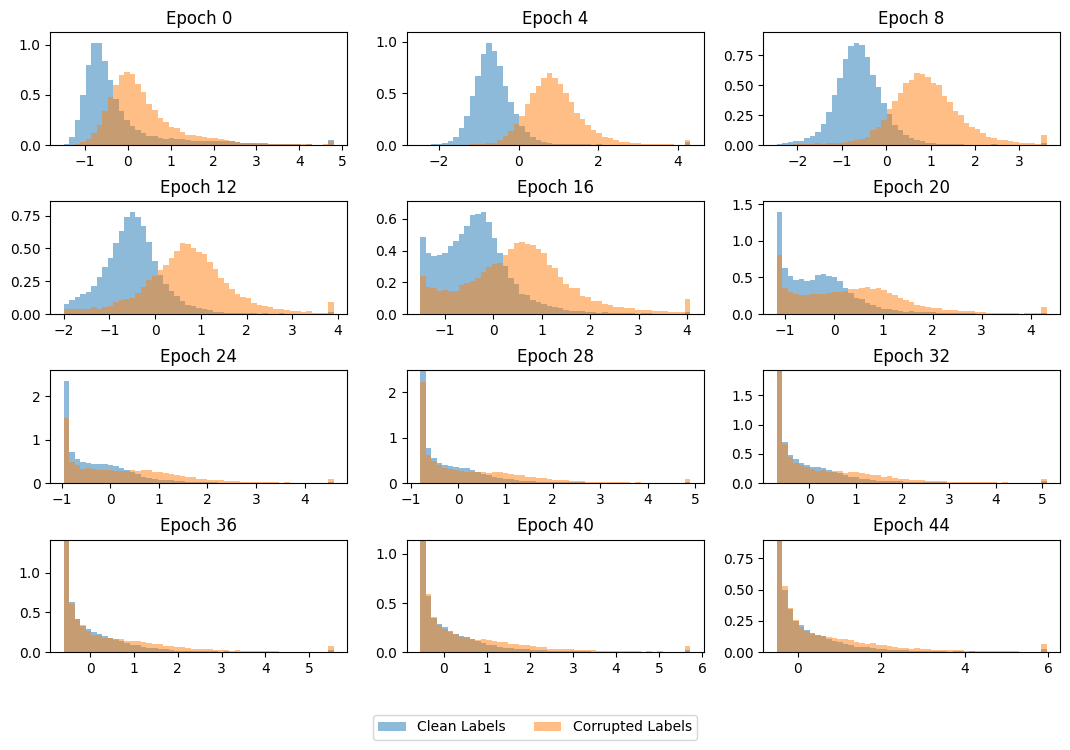

  0%|          | 0/48 [00:00<?, ?it/s]

/home/flypew/ML/Projects/2025-Project-175/.venv/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


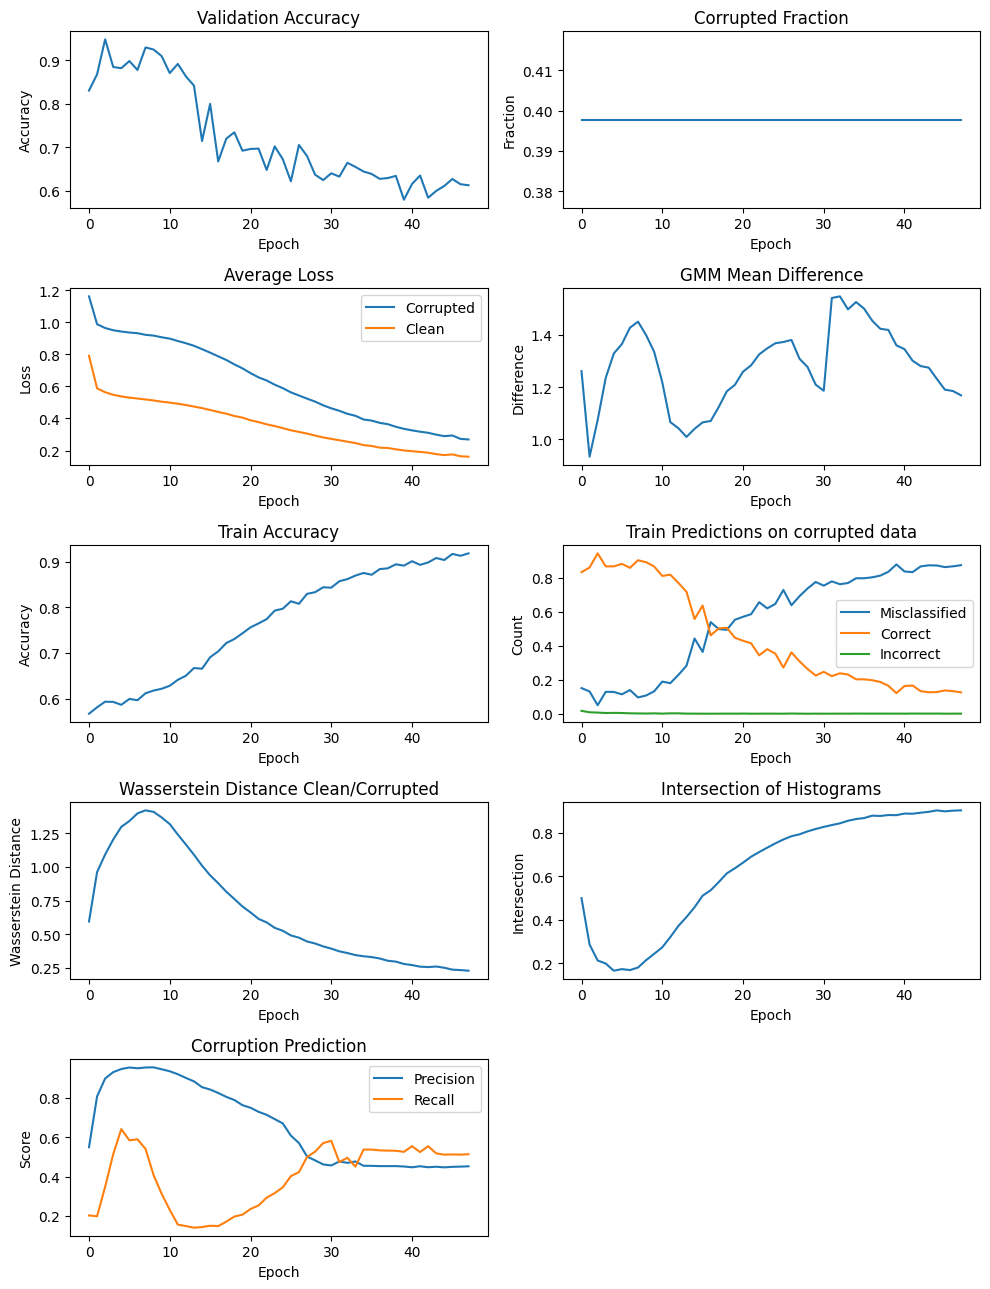

In [56]:
plot_insights('adamw_mnist_base')

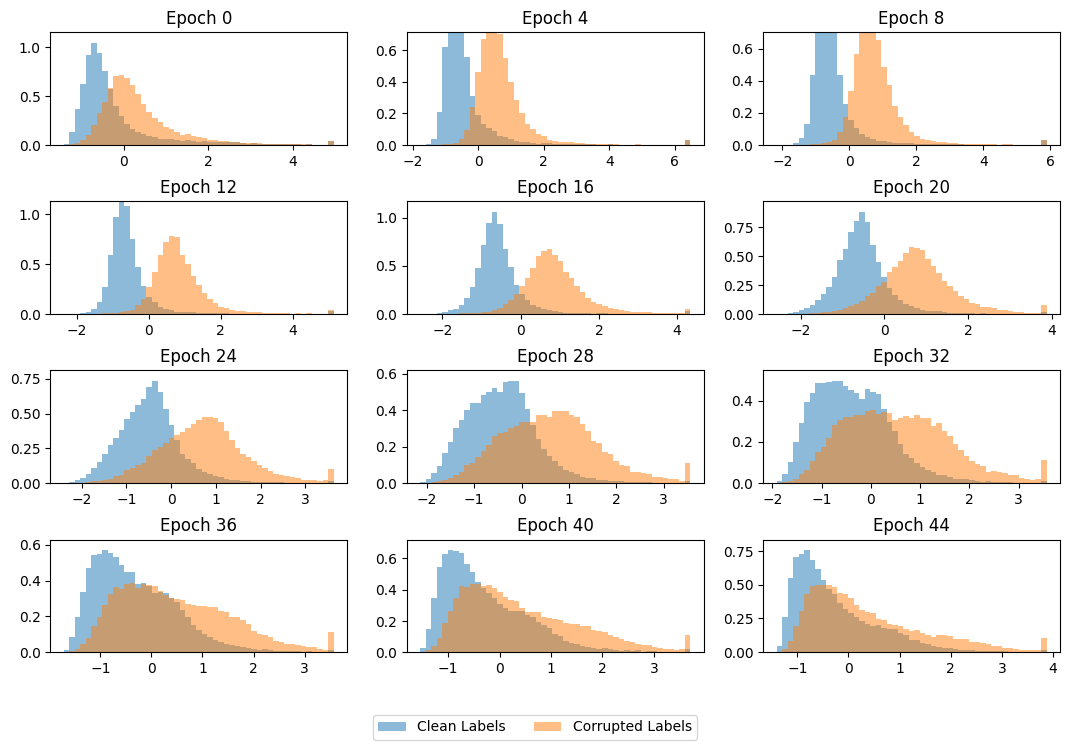

  0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_708726/501698908.py:88: RuntimeWarning: invalid value encountered in divide
  return d_corrupted.pdf(loss) * 0.36 / (0.64 * d_clean.pdf(loss) + 0.36 * d_corrupted.pdf(loss))


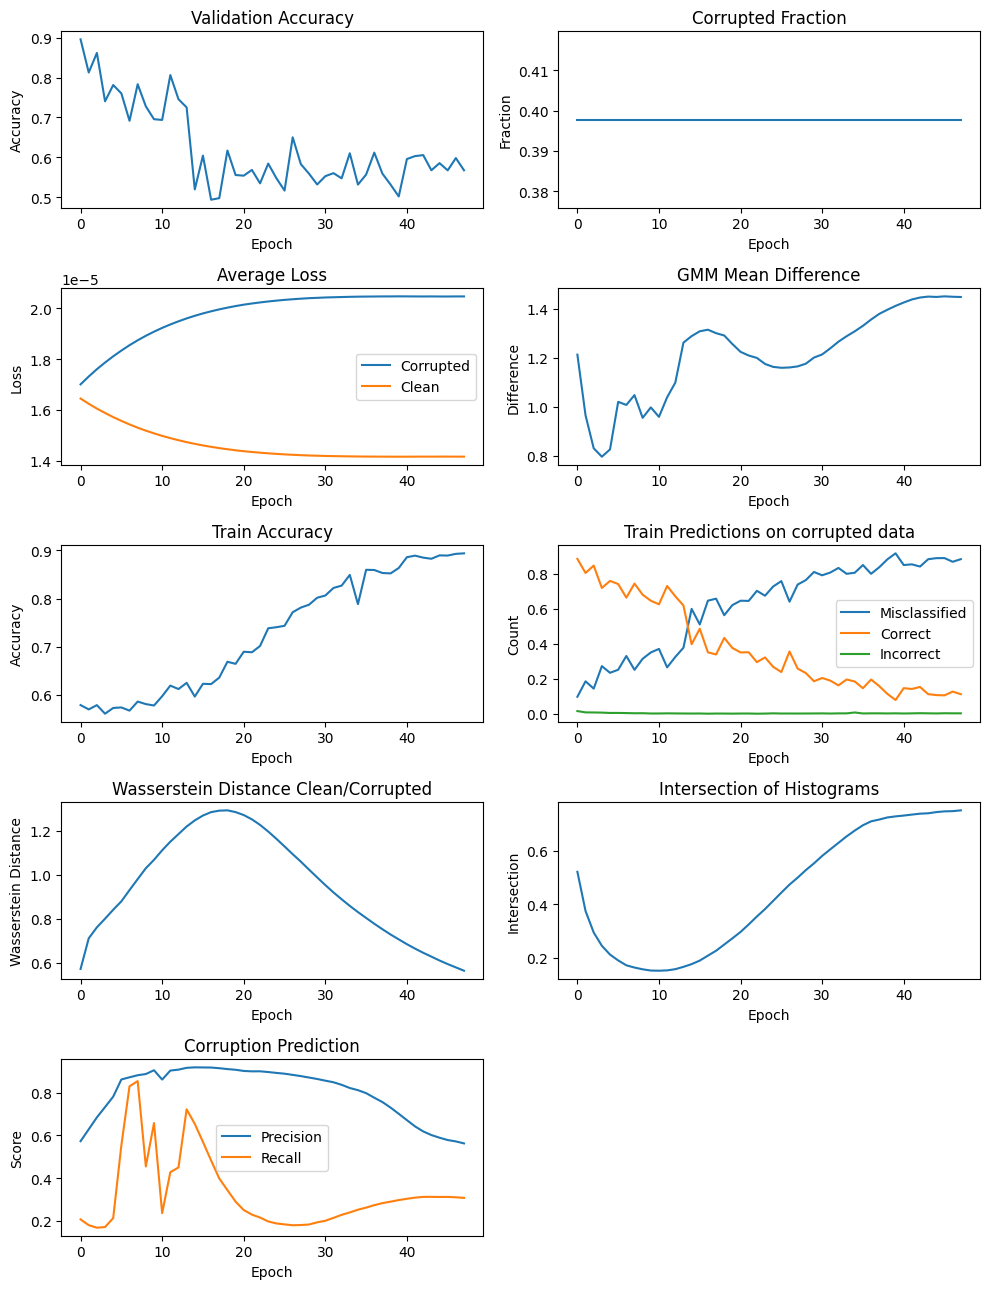

In [57]:
plot_insights('adversarial_mnist_base')